In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../Kaggle_dataset/ACWI3.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,48.919998,49.070000,48.709999,49.040001,41.957142,2298300
1,1/3/2013,48.810001,49.080002,48.720001,48.830002,41.777470,1567500
2,1/4/2013,48.840000,49.099998,48.750000,49.040001,41.957142,1400200
3,1/7/2013,48.790001,48.889999,48.669998,48.840000,41.786026,1497400
4,1/8/2013,48.709999,48.750000,48.430000,48.599998,41.580692,306300


In [3]:
from collections import deque
import random


class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 10
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
epoch: 10, total rewards: 11.039990.3, cost: 0.002573, total money: 10011.039990
epoch: 20, total rewards: 14.079994.3, cost: 0.001999, total money: 10014.079994
epoch: 30, total rewards: 12.439995.3, cost: 0.001934, total money: 10012.439995
epoch: 40, total rewards: 11.560013.3, cost: 0.001920, total money: 10011.560013
epoch: 50, total rewards: 2.739994.3, cost: 0.001820, total money: 10002.739994
epoch: 60, total rewards: 7.279991.3, cost: 0.001689, total money: 10007.279991
epoch: 70, total rewards: 5.370003.3, cost: 0.001742, total money: 10005.370003
epoch: 80, total rewards: 13.189995.3, cost: 0.001689, total money: 10013.189995
epoch: 90, total rewards: 14.099987.3, cost: 0.001983, total money: 10014.099987
epoch: 100, total rewards: 20.579975.3, cost: 0.001600, total money: 10020.579975
epoch: 110, tot

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 49.040001, total balance 9950.959999
day 1, sell 1 unit at price 48.830002, investment -0.428220 %, total balance 9999.790001,
day 2: buy 1 unit at price 49.040001, total balance 9950.750000
day 3, sell 1 unit at price 48.840000, investment -0.407832 %, total balance 9999.590000,
day 4: buy 1 unit at price 48.599998, total balance 9950.990002
day 5: buy 1 unit at price 48.770000, total balance 9902.220001
day 7, sell 1 unit at price 49.270000, investment 1.378605 %, total balance 9951.490002,
day 8: buy 1 unit at price 49.279999, total balance 9902.210003
day 10, sell 1 unit at price 49.180000, investment 0.840680 %, total balance 9951.390003,
day 11, sell 1 unit at price 49.520000, investment 0.487016 %, total balance 10000.910004,
day 14: buy 1 unit at price 49.650002, total balance 9951.260002
day 16, sell 1 unit at price 50.049999, investment 0.805635 %, total balance 10001.310001,
day 17: buy 1 unit at price 49.880001, total balance 9951.430000
day 18, s

day 298, sell 1 unit at price 57.580002, investment -1.234987 %, total balance 9995.689987,
day 301: buy 1 unit at price 56.509998, total balance 9939.179989
day 303: buy 1 unit at price 57.520000, total balance 9881.659988
day 306, sell 1 unit at price 56.980000, investment 0.831713 %, total balance 9938.639988,
day 307: buy 1 unit at price 56.910000, total balance 9881.729988
day 308, sell 1 unit at price 57.349998, investment -0.295553 %, total balance 9939.079987,
day 309, sell 1 unit at price 57.160000, investment 0.439290 %, total balance 9996.239986,
day 311: buy 1 unit at price 57.720001, total balance 9938.519985
day 313: buy 1 unit at price 58.560001, total balance 9879.959984
day 314: buy 1 unit at price 58.700001, total balance 9821.259983
day 315, sell 1 unit at price 58.580002, investment 1.489953 %, total balance 9879.839985,
day 316, sell 1 unit at price 58.150002, investment -0.700136 %, total balance 9937.989986,
day 317, sell 1 unit at price 57.740002, investment -1.

day 651, sell 1 unit at price 59.689999, investment 0.268772 %, total balance 10001.499996,
day 654: buy 1 unit at price 59.439999, total balance 9942.059998
day 657: buy 1 unit at price 59.209999, total balance 9882.849998
day 658, sell 1 unit at price 59.150002, investment -0.487882 %, total balance 9942.000000,
day 660: buy 1 unit at price 59.310001, total balance 9882.689999
day 663: buy 1 unit at price 57.189999, total balance 9825.500000
day 664, sell 1 unit at price 55.560001, investment -6.164495 %, total balance 9881.060001,
day 665, sell 1 unit at price 53.459999, investment -9.863433 %, total balance 9934.520000,
day 666, sell 1 unit at price 53.360001, investment -6.696972 %, total balance 9987.880001,
day 678: buy 1 unit at price 55.419998, total balance 9932.460003
day 680: buy 1 unit at price 55.700001, total balance 9876.760002
day 682, sell 1 unit at price 56.400002, investment 1.768321 %, total balance 9933.160004,
day 683: buy 1 unit at price 55.250000, total balance

day 1016: buy 1 unit at price 60.700001, total balance 9929.189976
day 1017, sell 1 unit at price 60.509998, investment -0.313019 %, total balance 9989.699974,
day 1022: buy 1 unit at price 60.830002, total balance 9928.869972
day 1023: buy 1 unit at price 61.430000, total balance 9867.439972
day 1024: buy 1 unit at price 61.310001, total balance 9806.129971
day 1026, sell 1 unit at price 60.799999, investment -0.049322 %, total balance 9866.929970,
day 1027, sell 1 unit at price 60.889999, investment -0.879051 %, total balance 9927.819969,
day 1028, sell 1 unit at price 60.919998, investment -0.636117 %, total balance 9988.739967,
day 1033: buy 1 unit at price 61.230000, total balance 9927.509968
day 1034, sell 1 unit at price 61.480000, investment 0.408297 %, total balance 9988.989967,
day 1035: buy 1 unit at price 61.730000, total balance 9927.259968
day 1036: buy 1 unit at price 62.020000, total balance 9865.239967
day 1037, sell 1 unit at price 62.150002, investment 0.680386 %, to

day 1201, sell 1 unit at price 69.269997, investment 0.072227 %, total balance 10001.460003,
day 1203: buy 1 unit at price 69.839996, total balance 9931.620007
day 1204, sell 1 unit at price 69.830002, investment -0.014311 %, total balance 10001.450008,
day 1205: buy 1 unit at price 70.000000, total balance 9931.450008
day 1206, sell 1 unit at price 70.070000, investment 0.100000 %, total balance 10001.520008,
day 1210: buy 1 unit at price 70.320000, total balance 9931.200008
day 1211, sell 1 unit at price 69.980003, investment -0.483499 %, total balance 10001.180012,
day 1216: buy 1 unit at price 70.080002, total balance 9931.100010
day 1217, sell 1 unit at price 70.300003, investment 0.313929 %, total balance 10001.400013,
day 1218: buy 1 unit at price 70.419998, total balance 9930.980015
day 1220: buy 1 unit at price 70.589996, total balance 9860.390018
day 1221: buy 1 unit at price 70.790001, total balance 9789.600018
day 1222, sell 1 unit at price 70.699997, investment 0.397613 %,

day 1522: buy 1 unit at price 68.230003, total balance 9799.330002
day 1524, sell 1 unit at price 67.500000, investment 0.701180 %, total balance 9866.830002,
day 1525, sell 1 unit at price 67.620003, investment 0.148113 %, total balance 9934.450005,
day 1526, sell 1 unit at price 68.370003, investment 0.205187 %, total balance 10002.820007,
day 1530: buy 1 unit at price 69.320000, total balance 9933.500008
day 1531, sell 1 unit at price 69.239998, investment -0.115409 %, total balance 10002.740005,
day 1532: buy 1 unit at price 69.639999, total balance 9933.100006
day 1533, sell 1 unit at price 70.050003, investment 0.588747 %, total balance 10003.150009,
day 1534: buy 1 unit at price 69.779999, total balance 9933.370010
day 1535, sell 1 unit at price 69.050003, investment -1.046139 %, total balance 10002.420013,
day 1544: buy 1 unit at price 70.769997, total balance 9931.650017
day 1545, sell 1 unit at price 71.199997, investment 0.607603 %, total balance 10002.850014,
day 1546: buy 

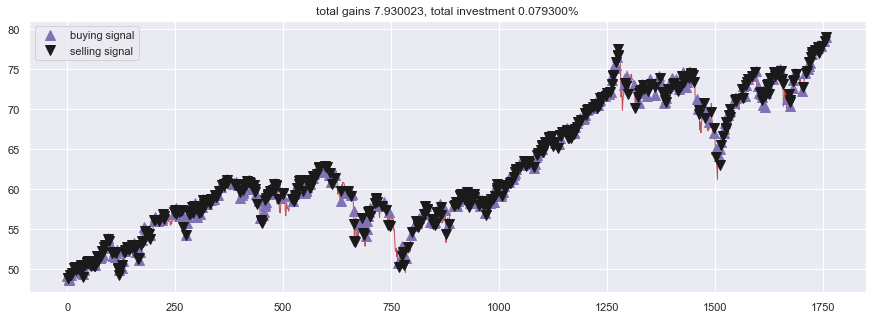

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=1)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()